In [1]:
from pathlib import Path
from typing import Iterable, List, Optional, Callable
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
from dvclive import Live

In [2]:
%load_ext watermark
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

matplotlib                 : 3.7.3
torchgeo                   : 0.5.2
segmentation_models_pytorch: 0.3.3
torch                      : 2.4.0.dev20240405+cu121
rasterio                   : 1.3.0.post1



In [146]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

In [151]:
from torchgeo.transforms import AugmentationSequential
# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=128, viz=False)
tfms = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

In [178]:
# Example usage
train_batch = {
    'image': torch.rand(1, 11, 256, 256),
    'mask': torch.rand(1, 1, 256, 256),
    'crs': [],
    'bbox': []
}
batch_tfms = [tfms, tfms_img]
if batch_tfms is not None:
    transformed = [tfm(train_batch) for tfm in batch_tfms][0]
#transformed = tfms(tfms_img(train_batch))

print("Transformed image shape:", transformed['image'].shape)
print("Transformed mask shape:", transformed['mask'].shape)

Transformed image shape: torch.Size([10, 13, 128, 128])
Transformed mask shape: torch.Size([10, 128, 128])


# Visualise a single image

In [7]:
from pathlib import  Path
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN")
assert root.exists()

# train_imgs = list((root/'images').glob('*.tif'))
# train_masks = list((root/'masks').glob('*.tif'))
train_imgs = list((root/'X').glob('*.tif'))
train_masks = list((root/'Y').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()

In [104]:
idx = 11
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

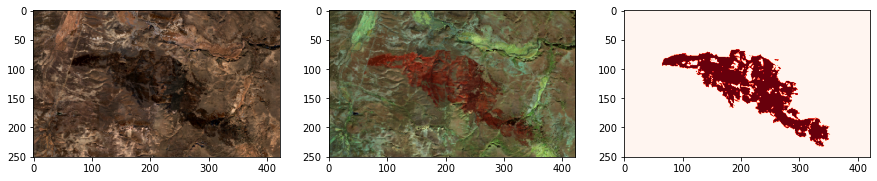

In [105]:
_, axs = plt.subplots(1, 3, figsize=(15, 6))

# plot the tile
FCI = [8, 6, 2]
TCI = [2, 1, 0]

rgb = img.data[TCI].transpose((1, 2, 0))*3#/17000
axs[0].imshow(rgb.clip(min=0, max=1))

rgb = img.data[FCI].transpose((1, 2, 0))*2#/25000
axs[1].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[2].imshow(mask.data.squeeze(), cmap='Reds')

In [106]:
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples

# train_ds = RasterDataset(paths=(root/'images').as_posix(), crs='epsg:4326', res= 0.00025)
train_ds = RasterDataset(paths=(root/'X').as_posix(), crs='epsg:4326', res= 0.00025)

In [107]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(train_ds, size= 64, length= 100)

In [108]:
import torch 

# this is to get the same result in every pass
torch.manual_seed(0)

bbox = next(iter(sampler))
sample = train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)

c:\ProgramData\Anaconda3\envs\erthy\lib\site-packages\rasterio\merge.py:317: UserWarning: The nodata value, -inf, is beyond the valid range of the chosen data type, float32. Consider overriding it using the --nodata option for better results.
  warnings.warn(


dict_keys(['crs', 'bbox', 'image'])
torch.Size([11, 64, 64])


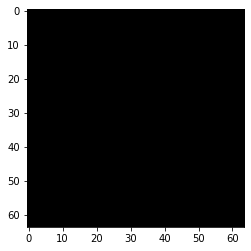

In [109]:
import torch
import matplotlib.pyplot as plt

arr = torch.clamp(sample['image'], min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)[:, :, [8, 6, 2]]

plt.imshow(3*rgb.clip(min=0, max=1))

In [110]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

# Creating the datasets

In [4]:
import os
import shutil
import random
from tqdm.auto import tqdm

def split_data(root, image_folder, mask_folder, train_ratio=0.8, seed=None, fromRep=None, toRep=None):
    # Create train and test directories if they don't exist
    train_dir = os.path.join(root, 'train')
    test_dir = os.path.join(root, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Create image and mask folders within train and test directories
    train_image_dir = os.path.join(train_dir, 'images')
    train_mask_dir = os.path.join(train_dir, 'masks')
    test_image_dir = os.path.join(test_dir, 'images')
    test_mask_dir = os.path.join(test_dir, 'masks')
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Get list of TIFF image filenames
    image_filenames = [filename for filename in os.listdir(os.path.join(root, image_folder)) if filename.endswith('.tif')]

    # Set random seed for reproducibility
    random.seed(seed)

    # Randomly shuffle filenames
    random.shuffle(image_filenames)

    # Calculate number of samples for train and test
    num_samples = len(image_filenames)
    num_train_samples = int(num_samples * train_ratio)
    num_test_samples = num_samples - num_train_samples

    # Split images into train and test sets
    train_images = image_filenames[:num_train_samples]
    test_images = image_filenames[num_train_samples:]

    # Move images and masks to train and test directories
    for image_name in tqdm(train_images, desc='Copying train images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.copy(image_path, os.path.join(train_image_dir, image_name))
            shutil.copy(mask_path, os.path.join(train_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    for image_name in tqdm(test_images, desc='Copying test images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.copy(image_path, os.path.join(test_image_dir, image_name))
            shutil.copy(mask_path, os.path.join(test_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    print("Data split completed. Train samples:", num_train_samples, "Test samples:", num_test_samples)

# Example usage
dirname = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN"
split_data(dirname, 'X', 'Y', train_ratio=0.8, seed=42, fromRep='image_', toRep='label_')


Copying train images and masks:   0%|          | 0/740 [00:00<?, ?it/s]

Either image image_73.tif or mask label_73.tif does not exist.
Either image image_855.tif or mask label_855.tif does not exist.
Either image image_1211.tif or mask label_1211.tif does not exist.
Either image image_24.tif or mask label_24.tif does not exist.
Either image image_690.tif or mask label_690.tif does not exist.
Either image image_848.tif or mask label_848.tif does not exist.
Either image image_660.tif or mask label_660.tif does not exist.
Either image image_18.tif or mask label_18.tif does not exist.
Either image image_1399.tif or mask label_1399.tif does not exist.
Either image image_1098.tif or mask label_1098.tif does not exist.
Either image image_856.tif or mask label_856.tif does not exist.
Either image image_892.tif or mask label_892.tif does not exist.
Either image image_917.tif or mask label_917.tif does not exist.
Either image image_250.tif or mask label_250.tif does not exist.
Either image image_176.tif or mask label_176.tif does not exist.
Either image image_613.ti

Copying test images and masks:   0%|          | 0/185 [00:00<?, ?it/s]

Either image image_853.tif or mask label_853.tif does not exist.
Either image image_172.tif or mask label_172.tif does not exist.
Either image image_184.tif or mask label_184.tif does not exist.
Either image image_459.tif or mask label_459.tif does not exist.
Either image image_1111.tif or mask label_1111.tif does not exist.
Either image image_989.tif or mask label_989.tif does not exist.
Either image image_981.tif or mask label_981.tif does not exist.
Data split completed. Train samples: 740 Test samples: 185


In [5]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images"
process_images(directory)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [6]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -2147483648] = 0
            
            # Update metadata
            profile = src.profile
            # profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\masks"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\masks"
process_images(directory)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [7]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np
import torch

def process_images(directory, num_classes):
    # List all files in the folder with a .tif extension
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        
        try:
            with rasterio.open(filepath) as src:
                # Read all bands data
                bands_data = src.read()
                
                # Assuming the target tensor is one of the bands or derived from the bands
                # Example: using the first band as the target tensor (customize as needed)
                target_tensor = torch.tensor(bands_data[0], dtype=torch.long)
                
                # Check if all values in the target tensor are within valid class indices
                if not torch.all((target_tensor >= 0) & (target_tensor < num_classes)):
                    print(f"Error: {filename} contains invalid class indices.")
                    print(target_tensor)
        
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\masks"
process_images(directory, 2)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\masks"
process_images(directory, 2)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [ ]:
# remove V.* bands
import os
import rasterio
from tqdm.auto import tqdm

def process_images(directory, delete=False):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Check for band names starting with 'V'
            band_names = src.descriptions
            bands_to_keep = [i + 1 for i, name in enumerate(band_names) if not name.startswith('V')]

            if not bands_to_keep:
                # If no bands to keep, skip or delete the image
                if delete:
                    src.close()
                    os.remove(filepath)
                    print(f"Deleted {filename} because it contains only 'V' bands.")
                else:
                    print(f"Skipped {filename} because it contains only 'V' bands.")
                continue

            if len(bands_to_keep) != len(band_names):
                # Read selected bands and metadata
                bands_data = [src.read(band) for band in bands_to_keep]
                profile = src.profile

        if bands_to_keep:
            # Update metadata
            profile.update(count=len(bands_to_keep))

            # Overwrite the image with the selected bands
            with rasterio.open(filepath, 'w', **profile) as dst:
                for idx, band_data in enumerate(bands_data, start=1):
                    dst.write(band_data, idx)
            print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images"
process_images(directory, delete=False)
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images"
# process_images(directory, delete=False)


# Visualise batch data

In [111]:
from pathlib import Path
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torch.utils.data import DataLoader

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()

train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False

In [155]:
sampler = RandomGeoSampler(train_imgs, size=256, length=30, units=Units.PIXELS)

In [156]:
# let's get a random bounding box, just to check the datasets
bbox = next(iter(sampler))

In [157]:

img_sample = train_imgs[bbox]
msk_sample = train_msks[bbox]

print(img_sample.keys(), msk_sample.keys())

dict_keys(['crs', 'bbox', 'image']) dict_keys(['crs', 'bbox', 'mask'])


In [158]:

# let's assert the patches cover the same region...
print(img_sample['bbox'])
print(msk_sample['bbox'])
assert img_sample['bbox'] == msk_sample['bbox']

BoundingBox(minx=-151.8951513605364, maxx=-151.8311513605364, miny=63.3886632905699, maxy=63.4526632905699, mint=0.0, maxt=9.223372036854776e+18)
BoundingBox(minx=-151.8951513605364, maxx=-151.8311513605364, miny=63.3886632905699, maxy=63.4526632905699, mint=0.0, maxt=9.223372036854776e+18)


In [159]:
train_dset = train_imgs & train_msks

In [160]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [161]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [162]:
from typing import Iterable, List
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 1.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Reds')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [8, 6, 2]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

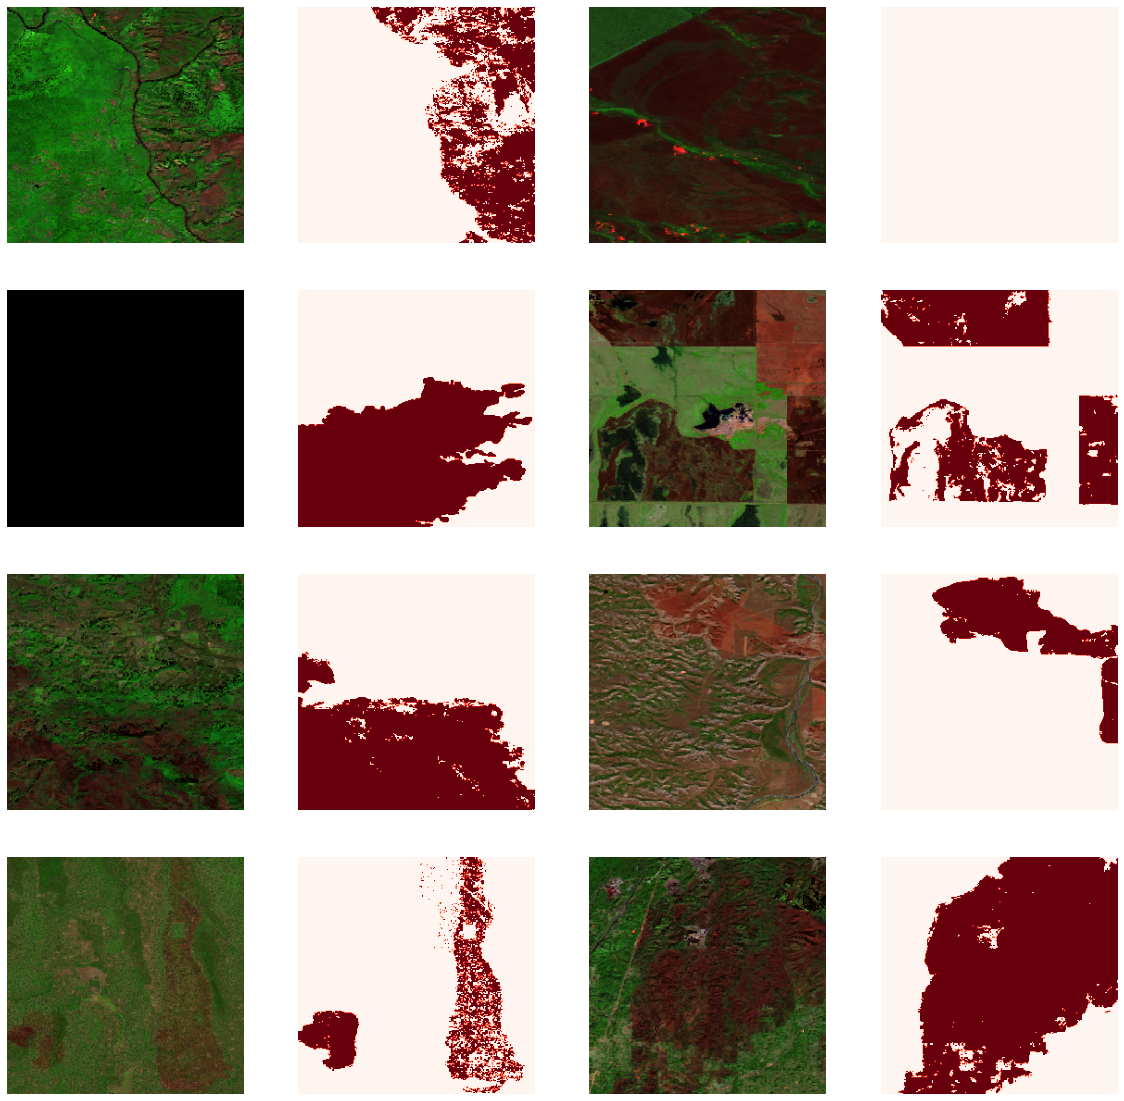

In [163]:
plot_batch(batch, 1.5)

In [164]:
from torchgeo.transforms import indices

ndwi_transform = indices.AppendNDWI(index_green=2, index_nir=4)

transformed_batch = ndwi_transform(batch['image'])
print(batch['image'].shape)
print(transformed_batch.shape)


torch.Size([8, 11, 256, 256])
torch.Size([8, 12, 256, 256])


In [10]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=128, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

dataloader = DataLoader(train_dset, sampler=sampler, batch_size=1, collate_fn=stack_samples)
batch = next(iter(dataloader))
print(batch.keys())
x = batch
print(x['image'].shape)
x = tfms_img(x)
print(x['image'].shape)

# print(tfms_both(x)['image'].shape)
x = tfms_fns(x)
print(x['mask'].unsqueeze(1).shape)

NameError: name 'sampler' is not defined

In [170]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [171]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=13,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [172]:
pred = model(torch.randn(3, 13, 64, 64, device = device))
pred.shape

torch.Size([3, 2, 64, 64])

In [188]:
from typing import Dict 
def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        optimizer.train()
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                        # if multiple transforms, Apply transforms iteratively
                        if isinstance(batch_tfms, list):
                            batch = [tfm(batch) for tfm in batch_tfms][0]
                        else:
                            batch = batch_tfms(batch)

            X = batch['image'].to(device)
            y = batch['mask'].unsqueeze(1).type(torch.long).to(device)
            pred = model(torch.nan_to_num(X))
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)
        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        # if multiple transforms, Apply transforms iteratively
                        if isinstance(batch_tfms, list):
                            batch = [tfm(batch) for tfm in batch_tfms][0]
                        else:
                            batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).to(device)
                    y = batch['mask'].unsqueeze(1).type(torch.long).to(device)

                    pred = model(torch.nan_to_num(X))
                    val_loss = loss_fn(pred, y)
                    accum_val_loss += float(val_loss)/len(val_dl)

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Eval Accs={[round(a, 3) for a in acc]}')
        else:
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.get('metric_index')]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.get("save_model_path"))
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        with Live(save_dvc_exp=True) as live:
            for param_name, param_value in train_params.items():
                live.log_param(param_name, param_value)
            live.log_metric("model_saving_score", chkpt_score)
            live.log_metric("Train loss", accum_loss)
            live.log_metric("Val_loss", accum_val_loss)

In [189]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [8]:
train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\images').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

# from torchgeo.samplers import RandomBatchGeoSampler
# train_sampler = RandomBatchGeoSampler(train_dset, size = 64, batch_size= 10, length=1000)
# valid_sampler = RandomBatchGeoSampler(valid_dset, size = 64, batch_size= 10, length=1000)

# train_dataloader = DataLoader(train_dset, batch_sampler=train_sampler, collate_fn=stack_samples)
# valid_dataloader = DataLoader(valid_dset, batch_sampler=valid_sampler, collate_fn=stack_samples)


train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 711, units=Units.PIXELS)#667
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 178, units=Units.PIXELS)#287

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 1, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 1, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [193]:
import schedulefree
train_params = {'lr': 0.0025, #0.0001
                'weight_decay': 0.01,
                'epochs': 100,
                'metric_index': 1,
                'save_model_path': r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth"}

loss_fn = smp.losses.LovaszLoss(mode= 'multiclass')
# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=train_params.get('lr'))
train_loop(epochs = train_params.get('epochs'), train_dl = train_dataloader, val_dl= valid_dataloader, model = model, loss_fn = loss_fn, optimizer = optimizer, 
           acc_fns=[oa, iou], batch_tfms= [tfms_img, tfms_fns], train_params = train_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.35549 - Eval Accs=[0.816, 0.543]
Saving model with validation score: 0.5430 at epoch 1


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 2: Train Loss=0.29081 - Eval Accs=[0.835, 0.555]
Saving model with validation score: 0.5550 at epoch 2


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 3: Train Loss=0.27467 - Eval Accs=[0.822, 0.559]
Saving model with validation score: 0.5590 at epoch 3


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 4: Train Loss=0.28917 - Eval Accs=[0.83, 0.574]
Saving model with validation score: 0.5744 at epoch 4


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 5: Train Loss=0.26613 - Eval Accs=[0.856, 0.615]
Saving model with validation score: 0.6147 at epoch 5


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 6: Train Loss=0.27147 - Eval Accs=[0.876, 0.678]
Saving model with validation score: 0.6778 at epoch 6


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 7: Train Loss=0.26087 - Eval Accs=[0.8, 0.47]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 8: Train Loss=0.26093 - Eval Accs=[0.796, 0.489]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 9: Train Loss=0.25982 - Eval Accs=[0.87, 0.628]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 10: Train Loss=0.25418 - Eval Accs=[0.837, 0.541]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 11: Train Loss=0.25329 - Eval Accs=[0.751, 0.398]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 12: Train Loss=0.24827 - Eval Accs=[0.848, 0.559]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 13: Train Loss=0.25030 - Eval Accs=[0.847, 0.608]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 14: Train Loss=0.24381 - Eval Accs=[0.841, 0.552]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 15: Train Loss=0.24552 - Eval Accs=[0.814, 0.575]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 16: Train Loss=0.25739 - Eval Accs=[0.835, 0.529]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 17: Train Loss=0.25060 - Eval Accs=[0.877, 0.664]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 18: Train Loss=0.25219 - Eval Accs=[0.866, 0.647]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 19: Train Loss=0.24835 - Eval Accs=[0.888, 0.675]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 20: Train Loss=0.23663 - Eval Accs=[0.738, 0.4]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 21: Train Loss=0.23282 - Eval Accs=[0.861, 0.65]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 22: Train Loss=0.26000 - Eval Accs=[0.73, 0.369]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 23: Train Loss=0.23001 - Eval Accs=[0.779, 0.471]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 24: Train Loss=0.23005 - Eval Accs=[0.807, 0.537]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 25: Train Loss=0.23009 - Eval Accs=[0.818, 0.543]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 26: Train Loss=0.24596 - Eval Accs=[0.708, 0.235]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 27: Train Loss=0.24673 - Eval Accs=[0.706, 0.239]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 28: Train Loss=0.23354 - Eval Accs=[0.77, 0.472]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 29: Train Loss=0.22292 - Eval Accs=[0.684, 0.306]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 30: Train Loss=0.23314 - Eval Accs=[0.664, 0.253]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 31: Train Loss=0.23547 - Eval Accs=[0.843, 0.645]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 32: Train Loss=0.21937 - Eval Accs=[0.801, 0.502]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 33: Train Loss=0.23217 - Eval Accs=[0.805, 0.523]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 34: Train Loss=0.22152 - Eval Accs=[0.622, 0.22]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 35: Train Loss=0.23351 - Eval Accs=[0.883, 0.672]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 36: Train Loss=0.24038 - Eval Accs=[0.619, 0.159]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 37: Train Loss=0.21457 - Eval Accs=[0.651, 0.25]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 38: Train Loss=0.23378 - Eval Accs=[0.861, 0.671]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 39: Train Loss=0.20517 - Eval Accs=[0.689, 0.256]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 40: Train Loss=0.21107 - Eval Accs=[0.722, 0.365]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 41: Train Loss=0.22784 - Eval Accs=[0.664, 0.284]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 42: Train Loss=0.22846 - Eval Accs=[0.748, 0.346]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


KeyboardInterrupt: 

# Plot predictions

In [1]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [3]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\images').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\masks').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)

In [ ]:
import geopandas as gpd
import numpy as np
import torch
from shapely.geometry import shape
from rasterio.features import shapes

# Assume `batch` is already defined, and `out` is the output from your model

def compute_iou(pred_mask, true_mask):
    """Computes the Intersection over Union (IoU) score."""
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0

def mask_to_polygons(mask, transform):
    """Converts a mask to polygons using rasterio and shapely."""
    polygons = []
    for geom, value in shapes(mask.astype(np.int16), mask=mask, transform=transform):
        polygons.append(shape(geom))
    return polygons

# Loop over the batch to compute IoU and convert labels to vectors
gdf_list = []
for i in range(len(batch['image'])):
    # Extract the reference mask and prediction
    true_mask = batch['mask'][i].cpu().numpy()  # Assuming the mask is in the batch
    pred_mask = out[i].cpu().detach().numpy() > 0.5  # Threshold the prediction to binary
    
    # Compute IoU
    iou_score = compute_iou(pred_mask, true_mask)
    
    # Convert true_mask to polygons
    transform = valid_msks.files[0].transform  # Replace with the correct transform if different
    polygons = mask_to_polygons(true_mask, transform)
    
    # Create a GeoDataFrame and store IoU as an attribute
    gdf = gpd.GeoDataFrame({'geometry': polygons, 'iou': [iou_score]*len(polygons)}, crs="EPSG:4326")
    
    gdf_list.append(gdf)

# Concatenate all GeoDataFrames into one
final_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


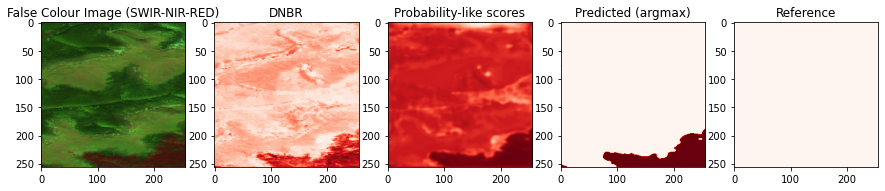

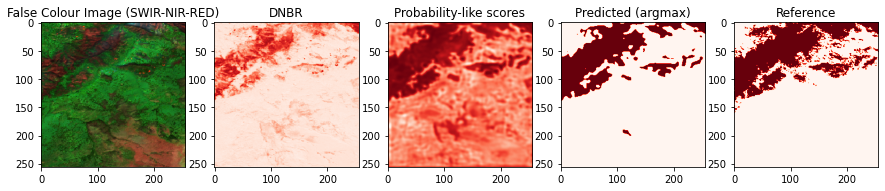

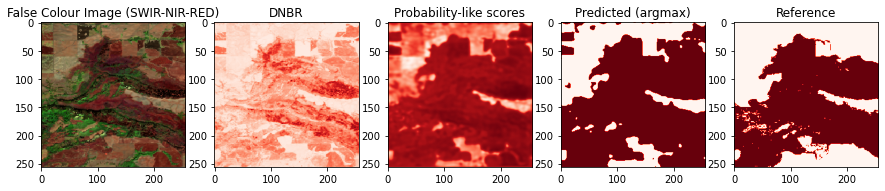

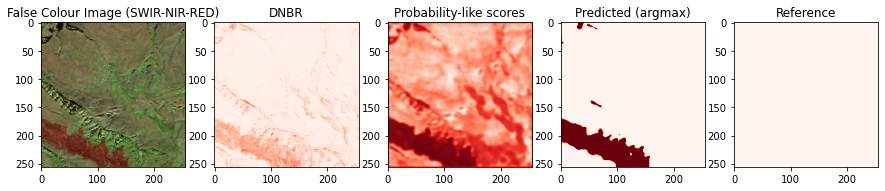

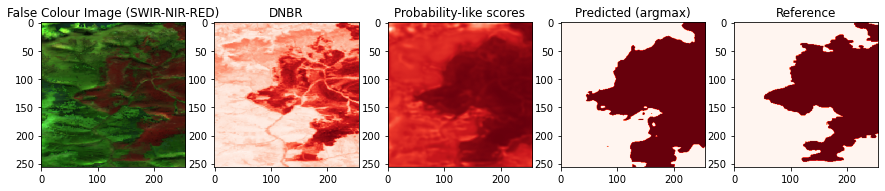

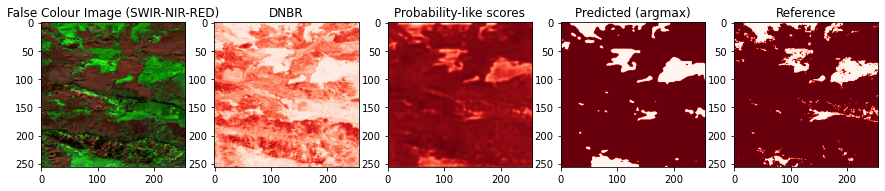

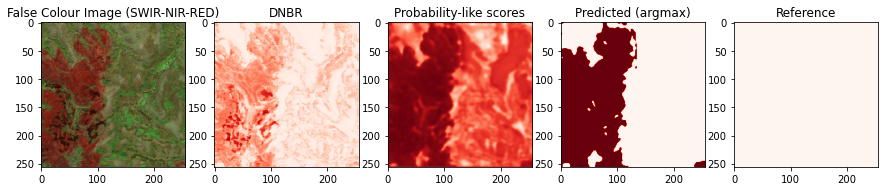

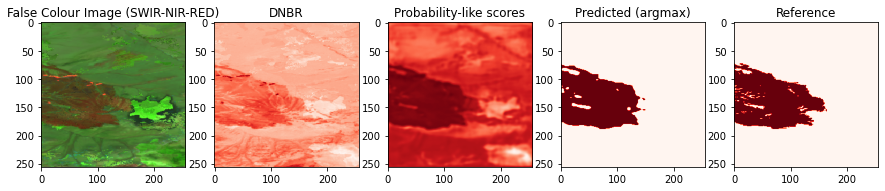

In [4]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 5, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted (argmax)',  'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        # plot the reference mask
        axs[4].imshow(mask.squeeze(), cmap='Reds')
        axs[4].set_title(labels[4])

plot_batch_preds(batch)


# SA Data

In [1]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
process_images(directory)


Processing images:   0%|          | 0/16 [00:00<?, ?it/s]

In [2]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [6]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
test_sampler = RandomGeoSampler(test_imgs, size= 256, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_imgs, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


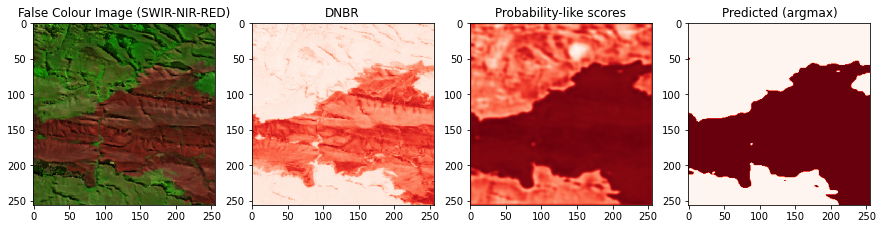

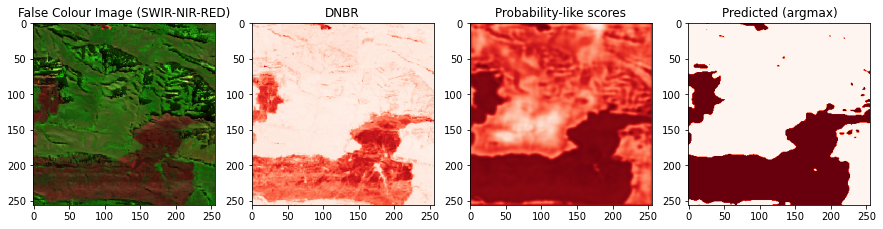

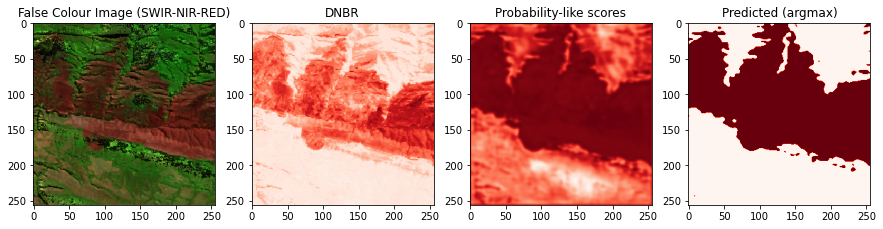

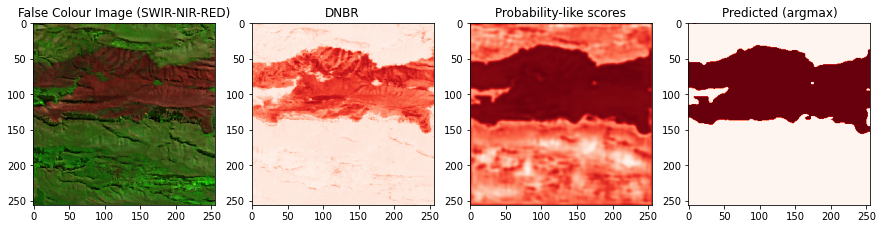

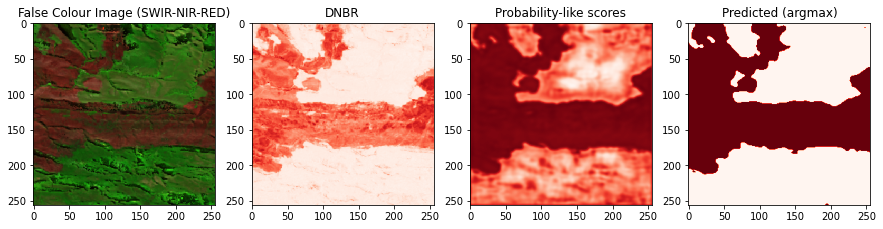

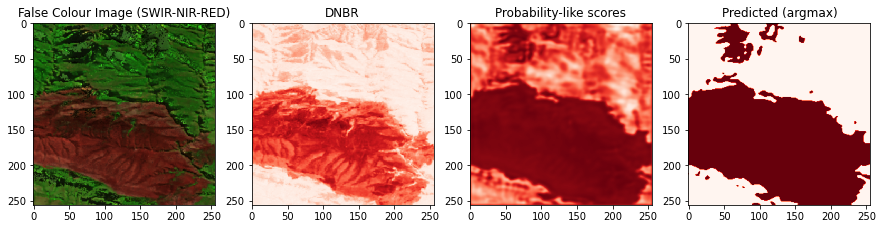

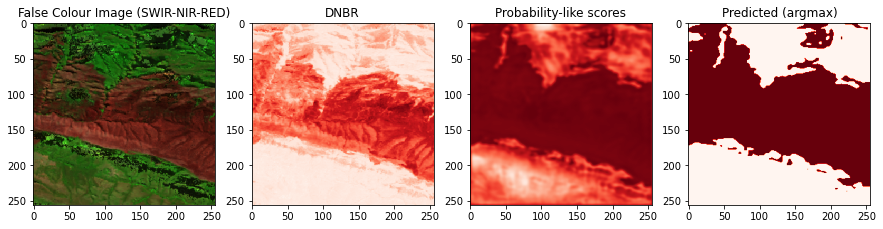

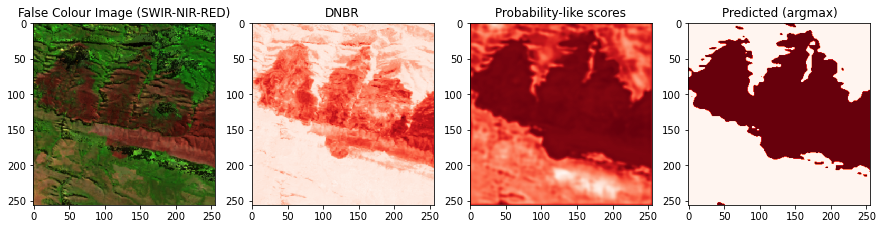

In [8]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 4, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted (argmax)',  'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
                
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

plot_batch_preds(batch)